# GRN-Focused Tutorial: Toggle Switch, Repressilator, and a T-cell Differentiation Toy

This notebook shows how to build small **gene regulatory network (GRN)** motifs using your Boolean toolbox, explore their dynamics, and visualize results.

**Motifs covered**
- Toggle switch (mutual repression)
- Repressilator (3-node cyclic inhibition)
- T-cell differentiation toy network (small decision circuit)

> Plots use only `matplotlib` and keep one chart per figure, as requested.


## 0. Setup & Imports

In [1]:
import sys, os, itertools, math
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt

# Use the uploaded toolbox
sys.path.append('/mnt/data')
import boolforge.analyze_BF as BF
import boolforge.analyze_BN as BN
import boolforge.generate as GEN
import boolforge.utils as utils

def successor_naive(F, I, x):
    """Compute synchronous successor without depending on BN helpers (fallback)."""
    nxt = np.zeros(len(F), dtype=int)
    for i, (fi, Ii) in enumerate(zip(F, I)):
        # Build local input index
        k = len(Ii)
        idx = 0
        for b in x[Ii]:
            idx = (idx << 1) | int(b)
        nxt[i] = fi[idx]
    return nxt

def all_states(N):
    return np.array([np.array(list(map(int, np.binary_repr(s, width=N)))) for s in range(2**N)], dtype=int)

def state_to_int(x):
    val = 0
    for b in x:
        val = (val << 1) | int(b)
    return val

def enumerate_state_graph(F, I):
    N = len(F)
    S = all_states(N)
    succ = {}
    for s in S:
        try:
            nxt = BN.successor_state(F, I, s)
        except Exception:
            nxt = successor_naive(F, I, s)
        succ[state_to_int(s)] = state_to_int(nxt)
    return succ

def find_attractors(F, I):
    # Try toolbox exact finder first
    try:
        attr, n = BN.get_attractors_synchronous_exact(F, I)
        return attr
    except Exception:
        pass
    # Fallback via cycle detection
    succ = enumerate_state_graph(F, I)
    seen = {}
    attractors = []
    for s in list(succ.keys()):
        if s in seen: 
            continue
        trail = []
        cur = s
        while cur not in seen:
            seen[cur] = True
            trail.append(cur)
            cur = succ[cur]
        if cur in trail:
            i = trail.index(cur)
            cyc = trail[i:]
            attractors.append([np.array(list(map(int, np.binary_repr(z, width=len(I)))), dtype=int) for z in cyc])
    return attractors

def basin_sizes(F, I, attractors):
    succ = enumerate_state_graph(F, I)
    # map an arbitrary state to an attractor index
    rep_to_idx = {}
    for i, cyc in enumerate(attractors):
        rep_to_idx[state_to_int(cyc[0])] = i
    # Assign every state to a cycle it reaches
    N = len(I)
    counts = Counter()
    for s in range(2**N):
        cur = s
        visited = set()
        while cur not in rep_to_idx and cur not in visited:
            visited.add(cur)
            cur = succ[cur]
        if cur in rep_to_idx:
            counts[rep_to_idx[cur]] += 1
    return [counts[i] for i in range(len(attractors))]

def simulate_trajectory(F, I, x0, T=20):
    path = [x0.copy()]
    x = x0.copy()
    for _ in range(T):
        try:
            x = BN.successor_state(F, I, x)
        except Exception:
            x = successor_naive(F, I, x)
        path.append(x.copy())
    return np.array(path, dtype=int)

def plot_basin_bar(basin_counts, title):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    x = np.arange(len(basin_counts))
    plt.bar(x, basin_counts)
    plt.xlabel("Attractor index")
    plt.ylabel("Basin size (states)")
    plt.title(title)
    plt.show()

def plot_timeseries(path, title, labels=None):
    import matplotlib.pyplot as plt
    fig = plt.figure()
    T, N = path.shape
    for i in range(N):
        plt.step(range(T), path[:, i] + 1.2*i, where='post', label=(labels[i] if labels else f'x{i+1}'))
    plt.yticks([])
    plt.xlabel("Time step")
    plt.title(title)
    plt.legend(loc='best')
    plt.show()


The module cana cannot be found. Ensure it is installed to use all functionality of this toolbox.
The module cana cannot be found. Ensure it is installed to use all functionality of this toolbox.


## 1. Toggle Switch (Mutual Repression)

A 2-gene toggle: each gene represses the other. Deterministic Boolean version:

- **x1' = NOT x2**
- **x2' = NOT x1**

Expected behavior: two fixed points (1,0) and (0,1), each with sizable basins (bistability).

Attractors (states in cycle): [[array([0, 0]), array([1, 1])], [array([0, 1])], [array([1, 0])]]
Basin sizes: [2, 1, 1]


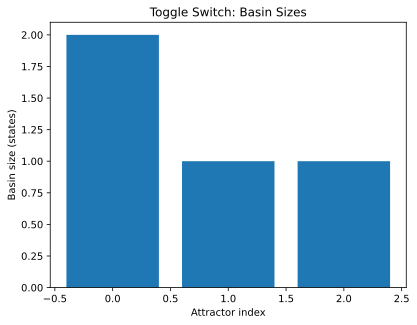

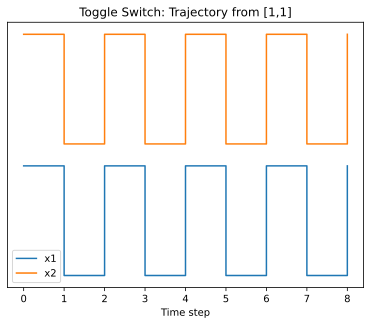

In [2]:
# Define toggle switch
# Gene 1 depends only on x2: NOT
f1 = np.array([1,0], dtype=int)  # input order: x2
# Gene 2 depends only on x1: NOT
f2 = np.array([1,0], dtype=int)  # input order: x1

F = [f1, f2]
I = [[1],[0]]  # regulators

# Find attractors and basins
attrs = find_attractors(F, I)
print('Attractors (states in cycle):', attrs)

basins = basin_sizes(F, I, attrs)
print('Basin sizes:', basins)

plot_basin_bar(basins, title="Toggle Switch: Basin Sizes")

# Example trajectory from [1,1]
path = simulate_trajectory(F, I, np.array([1,1], dtype=int), T=8)
plot_timeseries(path, "Toggle Switch: Trajectory from [1,1]", labels=['x1','x2'])


## 2. Repressilator (3-Node Ring of Inhibitions)

A 3-gene ring of inhibitions:

- **x1' = NOT x2**
- **x2' = NOT x3**
- **x3' = NOT x1**

Expected behavior (synchronous update): typically a 2-cycle (oscillation).

Attractors: [[array([0, 0, 0]), array([1, 1, 1])], [array([0, 0, 1]), array([1, 0, 1]), array([1, 0, 0]), array([1, 1, 0]), array([0, 1, 0]), array([0, 1, 1])]]
Basin sizes: [2, 6]


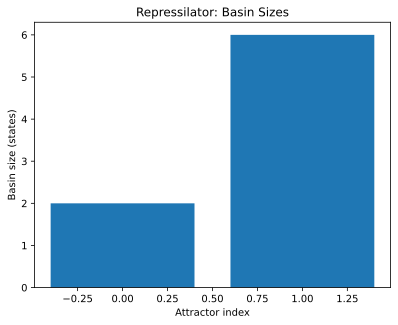

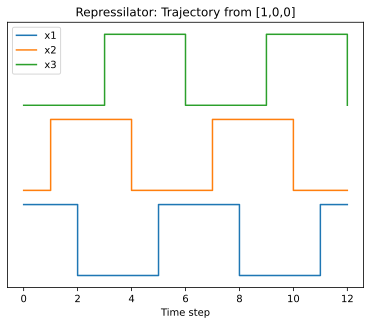

In [3]:
# Define repressilator
f_not = np.array([1,0], dtype=int)

F = [f_not, f_not, f_not]
I = [[1],[2],[0]]  # x1<-x2, x2<-x3, x3<-x1

attrs = find_attractors(F, I)
print('Attractors:', attrs)

basins = basin_sizes(F, I, attrs)
print('Basin sizes:', basins)
plot_basin_bar(basins, title="Repressilator: Basin Sizes")

# Show a trajectory from a random initial condition
x0 = np.array([1,0,0], dtype=int)
path = simulate_trajectory(F, I, x0, T=12)
plot_timeseries(path, "Repressilator: Trajectory from [1,0,0]", labels=['x1','x2','x3'])


## 3. T-cell Differentiation (Toy Circuit)

This is a minimalist toy capturing a **binary fate decision** flavor (not a faithful biological model).

Nodes:
- **T-bet (T)** promotes Th1; **GATA3 (G)** promotes Th2.
- Mutual inhibition T ⊣ G and G ⊣ T.
- A cytokine input **S** (signal) biases toward T-bet.

Update rules (Boolean caricature):
- **T' = (S OR T) AND NOT G**
- **G' = (NOT T) AND (NOT S)**
- **S' = S** (external condition held constant; we treat S as self-copy for simplicity)

We’ll examine how **S=0** (no bias) vs **S=1** (bias toward Th1) changes attractors and basins.

Truth tables lengths: [8, 8, 2]
Attractors (unrestricted S): [[array([0, 1, 0])], [array([1, 0, 1])], [array([1, 0, 0])]]
Attractors (S unrestricted): [[array([0, 1, 0])], [array([1, 0, 1])], [array([1, 0, 0])]]
Basin sizes with S=0 init: [3, 0, 1]
Basin sizes with S=1 init: [0, 4, 0]


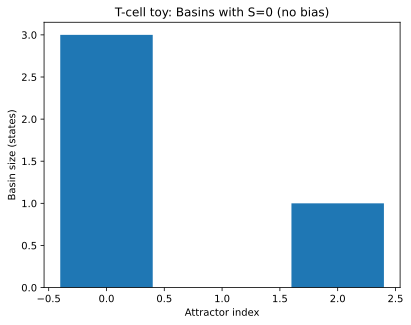

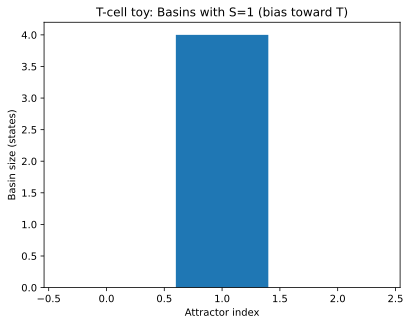

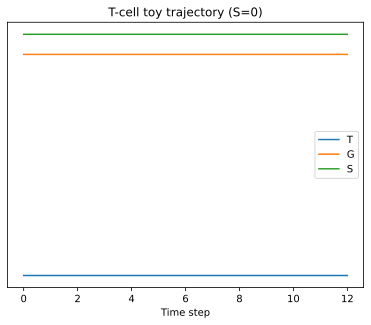

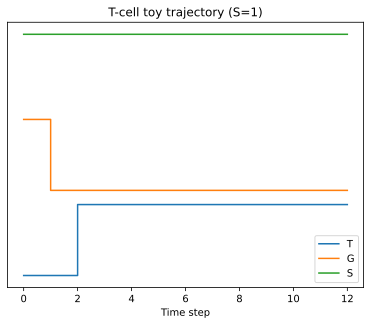

In [4]:
# Build truth tables for the toy T-cell circuit
# Variable order: [T, G, S]
# T' = (S OR T) AND NOT G
# G' = (NOT T) AND (NOT S)
# S' = S  (identity / held constant)

def truth_table_T():
    # Inputs to T are (T,G,S) but T' only depends on (T,G,S) as defined
    tb = []
    for T_val in [0,1]:
        for G_val in [0,1]:
            for S_val in [0,1]:
                Tb = (S_val or T_val) and (not G_val)
                tb.append(int(Tb))
    return np.array(tb, dtype=int)

def truth_table_G():
    tb = []
    for T_val in [0,1]:
        for G_val in [0,1]:
            for S_val in [0,1]:
                Gb = (not T_val) and (not S_val)
                tb.append(int(Gb))
    return np.array(tb, dtype=int)

def truth_table_S():
    # identity on S alone: inputs: [S]
    return np.array([0,1], dtype=int)

fT = truth_table_T()   # length 8
fG = truth_table_G()   # length 8
fS = truth_table_S()   # length 2

F = [fT, fG, fS]
I = [[0,1,2], [0,1,2], [2]]  # regulators: T depends on (T,G,S); G on (T,G,S); S on (S)

print('Truth tables lengths:', [len(f) for f in F])

attrs = find_attractors(F, I)
print('Attractors (unrestricted S):', attrs)

# Compare basins restricting to S=0 and S=1 initial states
def restricted_basin(F, I, S_fixed):
    N = 3
    succ = enumerate_state_graph(F, I)
    # Only consider states with S = S_fixed
    states = [s for s in range(2**N) if (s & 1) == S_fixed]  # with ordering [T,G,S], S is least significant bit
    # Identify attractor indices
    atts = find_attractors(F, I)
    rep_to_idx = {int("".join(map(str, a[0])), 2): i for i,a in enumerate(atts)} if atts else {}
    # Map each state to an attractor index
    counts = Counter()
    for s in states:
        cur = s
        visited = set()
        while cur not in rep_to_idx and cur not in visited:
            visited.add(cur)
            cur = succ[cur]
        if cur in rep_to_idx:
            counts[rep_to_idx[cur]] += 1
    return atts, [counts[i] for i in range(len(atts))]

atts0, bas0 = restricted_basin(F, I, S_fixed=0)
atts1, bas1 = restricted_basin(F, I, S_fixed=1)

print('Attractors (S unrestricted):', attrs)
print('Basin sizes with S=0 init:', bas0)
print('Basin sizes with S=1 init:', bas1)

plot_basin_bar(bas0, title="T-cell toy: Basins with S=0 (no bias)")
plot_basin_bar(bas1, title="T-cell toy: Basins with S=1 (bias toward T)")

# Example trajectories under S=0 and S=1 from same T,G but different S
x0 = np.array([0,1,0], dtype=int)  # start G=1,T=0, S=0
path0 = simulate_trajectory(F, I, x0, T=12)
plot_timeseries(path0, "T-cell toy trajectory (S=0)", labels=['T','G','S'])

x1 = np.array([0,1,1], dtype=int)  # same T,G but S=1
path1 = simulate_trajectory(F, I, x1, T=12)
plot_timeseries(path1, "T-cell toy trajectory (S=1)", labels=['T','G','S'])
